Processing folder: ../Images_data/training_set
Completed processing folder: ../Images_data/training_set
Processing folder: ../Images_data/test_set
Completed processing folder: ../Images_data/test_set
Encoding labels...
Labels encoded.
Normalizing pixel values...
>>>>>>>Tamanho do Treino: 3000 e Tamanho do Teste 2997<<<<<<<<<
Pixel values normalized.
Extracting features from training images...
Starting feature extraction...
Feature extraction completed.
Features extracted from training images.
Extracting features from test images...
Starting feature extraction...
Feature extraction completed.
Features extracted from test images.
Reshaping data for Random Forest...
Data reshaped for Random Forest.
Performing cross-validation...
Cross-validation accuracy scores: [0.81166667 0.84       0.815      0.80833333 0.82      ]
Mean cross-validation accuracy: 0.8190000000000002
Training Random Forest model...
Random Forest model trained.
Predicting on test data...
Prediction on test data completed.

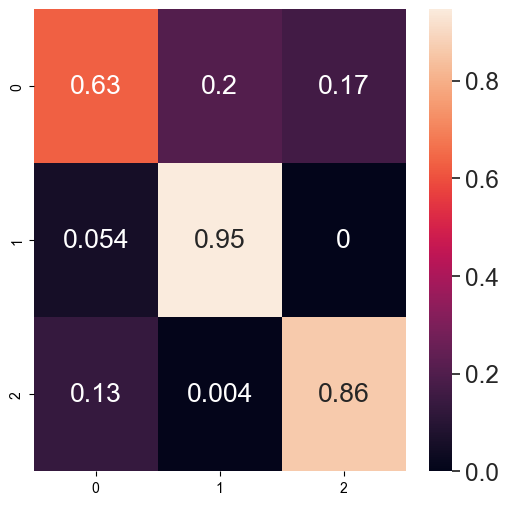

Confusion matrix displayed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor

# Resize images to
SIZE = 128
FOLDER_TEST = "../Images_data/test_set"
FOLDER_TRAIN = "../Images_data/training_set"
IMAGE_LIMIT = 1000

def load_image(img_path, size=SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (size, size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def load_images_from_subdirectory(subdirectory_path, size=SIZE, limit=IMAGE_LIMIT):
    print(f"Loading images from subdirectory: {subdirectory_path}")
    images = []
    labels = []
    image_count = 0
    for root, dirs, files in os.walk(subdirectory_path):
        for file in files:
            if file.endswith('.jpeg'):
                label = os.path.basename(root)
                img_path = os.path.join(root, file)
                img = load_image(img_path, size)
                images.append(img)
                labels.append(label)
                image_count += 1
                if image_count >= limit:
                    break
        if image_count >= limit:
            break
    print(f"Loaded {len(images)} images from {subdirectory_path}")
    return images, labels

def process_subdirectories(folder_path, size=SIZE):
    print(f"Processing folder: {folder_path}")
    subdirectories = [os.path.join(folder_path, d) for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    results = Parallel(n_jobs=-1)(delayed(load_images_from_subdirectory)(subdir, size) for subdir in subdirectories)
    images = [img for result in results for img in result[0]]
    labels = [label for result in results for label in result[1]]
    print(f"Completed processing folder: {folder_path}")
    return np.array(images), np.array(labels)

# Load training images
train_images, train_labels = process_subdirectories(FOLDER_TRAIN)

# Load test images
test_images, test_labels = process_subdirectories(FOLDER_TEST)

# Encode labels
print("Encoding labels...")
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
print("Labels encoded.")

# Normalize pixel values
print("Normalizing pixel values...")
x_train, x_test = train_images / 255.0, test_images / 255.0
print(f'>>>>>>>Tamanho do Treino: {len(x_train)} e Tamanho do Teste {len(x_test)}<<<<<<<<<')
print("Pixel values normalized.")

def extract_features(image):
    df = pd.DataFrame()
    img = image

    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values

    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            lamda = np.pi / 4
            gamma = 0.5
            ksize = 9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            kernels.append(kernel)
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            df[f'Gabor{num}'] = filtered_img
            num += 1

    edge_sobel = sobel(img).reshape(-1)
    df['Sobel'] = edge_sobel

    return df

def feature_extractor(dataset):
    print("Starting feature extraction...")
    with ThreadPoolExecutor() as executor:
        features = list(executor.map(extract_features, dataset))
    print("Feature extraction completed.")
    return pd.concat(features, ignore_index=True)

# Extract features
print("Extracting features from training images...")
image_features = feature_extractor(x_train)
print("Features extracted from training images.")
print("Extracting features from test images...")
test_features = feature_extractor(x_test)
print("Features extracted from test images.")

# Reshape for Random Forest
print("Reshaping data for Random Forest...")
X_for_RF = image_features.to_numpy().reshape(x_train.shape[0], -1)
test_for_RF = test_features.to_numpy().reshape(x_test.shape[0], -1)
print("Data reshaped for Random Forest.")

# Define Random Forest model
RF_model = RandomForestClassifier(n_estimators=124, max_depth=10, min_samples_split=73, min_samples_leaf=23, random_state=42)

# Perform cross-validation
print("Performing cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(RF_model, X_for_RF, train_labels_encoded, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")

# Train Random Forest model
print("Training Random Forest model...")
RF_model.fit(X_for_RF, train_labels_encoded)
print("Random Forest model trained.")

# Predict on test data
print("Predicting on test data...")
test_prediction = RF_model.predict(test_for_RF)
test_prediction = le.inverse_transform(test_prediction)
print("Prediction on test data completed.")

# Print accuracy
print("Calculating accuracy...")
accuracy = accuracy_score(test_labels, test_prediction)
print(f"Test Accuracy = {accuracy}")

# Print confusion matrix
print("Generating confusion matrix...")
cm = confusion_matrix(test_labels, test_prediction)
cm_normalized = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm_normalized, annot=True, ax=ax)
plt.show()
print("Confusion matrix displayed.")

### Playground

Starting image processing...
Completed image processing.
Starting image processing...
Completed image processing.
Encoding labels...
Labels encoded.
Normalizing pixel values...
Pixel values normalized.
Extracting features from training images...
Starting feature extraction...
Feature extraction completed.
Features extracted from training images.
Extracting features from test images...
Starting feature extraction...
Feature extraction completed.
Features extracted from test images.
Reshaping data for Random Forest...
Data reshaped for Random Forest.
Performing cross-validation...
Cross-validation accuracy scores: [0.65       0.65       0.68333333 0.68333333 0.76666667]
Mean cross-validation accuracy: 0.6866666666666668
Training Random Forest model...
Random Forest model trained.
Predicting on test data...
Prediction on test data completed.
Calculating accuracy...
Test Accuracy = 0.7266666666666667
Generating confusion matrix...


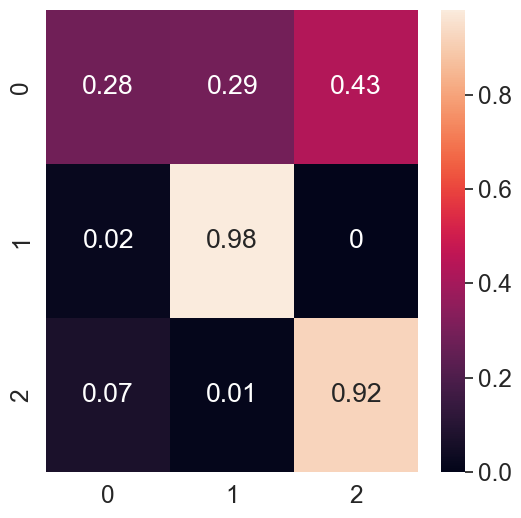

Confusion matrix displayed.


In [2]:
#V2: ALL IMAGES
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor

# Resize images to
SIZE = 128
FOLDER_TEST = "../Images_data/test_set_r/*"
FOLDER_TRAIN = "../Images_data/training_set_r/*"

def load_image(img_path, size=SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (size, size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def load_images_from_directory(directory_path, size=SIZE):
    print(f"Loading images from directory: {directory_path}")
    images = []
    labels = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.jpeg'):
                label = os.path.basename(root)
                img_path = os.path.join(root, file)
                img = load_image(img_path, size)
                images.append(img)
                labels.append(label)
    print(f"Loaded {len(images)} images from {directory_path}")
    return images, labels

def process_images(image_paths, size=SIZE):
    print("Starting image processing...")
    results = Parallel(n_jobs=-1)(delayed(load_images_from_directory)(path, size) for path in image_paths)
    images = [img for result in results for img in result[0]]
    labels = [label for result in results for label in result[1]]
    print("Completed image processing.")
    return np.array(images), np.array(labels)

# Load training images
train_paths = glob.glob(FOLDER_TRAIN)
train_images, train_labels = process_images(train_paths)

# Load test images
test_paths = glob.glob(FOLDER_TEST)
test_images, test_labels = process_images(test_paths)

# Encode labels
print("Encoding labels...")
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
print("Labels encoded.")

# Normalize pixel values
print("Normalizing pixel values...")
x_train, x_test = train_images / 255.0, test_images / 255.0
print("Pixel values normalized.")

def extract_features(image):
    df = pd.DataFrame()
    img = image

    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values

    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            lamda = np.pi / 4
            gamma = 0.5
            ksize = 9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            kernels.append(kernel)
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            df[f'Gabor{num}'] = filtered_img
            num += 1

    edge_sobel = sobel(img).reshape(-1)
    df['Sobel'] = edge_sobel

    return df

def feature_extractor(dataset):
    print("Starting feature extraction...")
    with ThreadPoolExecutor() as executor:
        features = list(executor.map(extract_features, dataset))
    print("Feature extraction completed.")
    return pd.concat(features, ignore_index=True)

# Extract features
print("Extracting features from training images...")
image_features = feature_extractor(x_train)
print("Features extracted from training images.")
print("Extracting features from test images...")
test_features = feature_extractor(x_test)
print("Features extracted from test images.")

# Reshape for Random Forest
print("Reshaping data for Random Forest...")
X_for_RF = image_features.to_numpy().reshape(x_train.shape[0], -1)
test_for_RF = test_features.to_numpy().reshape(x_test.shape[0], -1)
print("Data reshaped for Random Forest.")

# Define Random Forest model
RF_model = RandomForestClassifier(n_estimators=124, max_depth=10, min_samples_split=73, min_samples_leaf=23, random_state=42)

# Perform cross-validation
print("Performing cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(RF_model, X_for_RF, train_labels_encoded, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")

# Train Random Forest model
print("Training Random Forest model...")
RF_model.fit(X_for_RF, train_labels_encoded)
print("Random Forest model trained.")

# Predict on test data
print("Predicting on test data...")
test_prediction = RF_model.predict(test_for_RF)
test_prediction = le.inverse_transform(test_prediction)
print("Prediction on test data completed.")

# Print accuracy
print("Calculating accuracy...")
accuracy = accuracy_score(test_labels, test_prediction)
print(f"Test Accuracy = {accuracy}")

# Print confusion matrix
print("Generating confusion matrix...")
cm = confusion_matrix(test_labels, test_prediction)
cm_normalized = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm_normalized, annot=True, ax=ax)
plt.show()
print("Confusion matrix displayed.")


In [1]:
#V1
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import Parallel, delayed

In [2]:
# Resize images to
SIZE = 128
FOLDER_TEST = "../Images_data/test_set/*"
FOLDER_TRAIN = "../Images_data/training_set/*"

In [3]:
def load_images_from_directory(directory_path, size=SIZE):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.jpeg'):
                label = os.path.basename(root)
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (size, size))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img)
                labels.append(label)
    return images, labels

def process_images(image_paths, size=SIZE):
    results = Parallel(n_jobs=-1)(delayed(load_images_from_directory)(path, size) for path in image_paths)
    images = [img for result in results for img in result[0]]
    labels = [label for result in results for label in result[1]]
    return np.array(images), np.array(labels)

# Load training images
train_paths = glob.glob(FOLDER_TRAIN)
train_images, train_labels = process_images(train_paths)

# Load test images
test_paths = glob.glob(FOLDER_TEST)
test_images, test_labels = process_images(test_paths)

# Encode labels
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)

# Normalize pixel values
x_train, x_test = train_images / 255.0, test_images / 255.0

def feature_extractor(dataset):
    def extract_features(image):
        df = pd.DataFrame()
        img = image

        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values

        num = 1
        kernels = []
        for theta in range(2):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                lamda = np.pi / 4
                gamma = 0.5
                ksize = 9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[f'Gabor{num}'] = filtered_img
                num += 1

        edge_sobel = sobel(img).reshape(-1)
        df['Sobel'] = edge_sobel

        return df

    features = Parallel(n_jobs=-1)(delayed(extract_features)(img) for img in dataset)
    return pd.concat(features, ignore_index=True)

# Extract features
image_features = feature_extractor(x_train)
test_features = feature_extractor(x_test)

# Reshape for Random Forest
X_for_RF = image_features.to_numpy().reshape(x_train.shape[0], -1)
test_for_RF = test_features.to_numpy().reshape(x_test.shape[0], -1)

# Define Random Forest model
RF_model = RandomForestClassifier(n_estimators=124,max_depth=10,min_samples_split=73,min_samples_leaf=23, random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(RF_model, X_for_RF, train_labels_encoded, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")

# Train Random Forest model
RF_model.fit(X_for_RF, train_labels_encoded)

# Predict on test data
test_prediction = RF_model.predict(test_for_RF)
test_prediction = le.inverse_transform(test_prediction)

# Print accuracy
print("Test Accuracy =", accuracy_score(test_labels, test_prediction))

# Print confusion matrix
cm = confusion_matrix(test_labels, test_prediction)
cm_normalized = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm_normalized, annot=True, ax=ax)
plt.show()
